### SGD with Weight Decay and own network layer definitions
* load MNIST numpy version
* build linear layer + update function
* build 2 layer + update function
* implement weight decay for one of them
* swap own optimization to Adam

In [1]:
%matplotlib inline
from fastai.basics import *

In [5]:
path = Config().data_path()/'mnist'

In [6]:
path.ls()

[PosixPath('/home/CW01/uia94835/.fastai/data/mnist/mnist.pkl.gz')]

In [7]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [14]:
x_train.shape

(50000, 784)

5


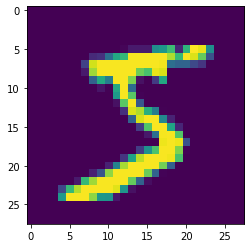

In [19]:
plt.imshow(x_train[0,:].reshape((28,28)))
print(y_train[0])

### Create torch tensors, then TensorDataset, then DataBunch from the numpy data

In [168]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

/home/CW01/uia94835/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [169]:
x_train.shape

torch.Size([50000, 784])

In [170]:
y_train.min()

tensor(0)

In [400]:
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)
train_dataset

In [401]:
data = DataBunch.create(train_dataset, valid_dataset, bs=64)
data

DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7fcdbe7f7090>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7fcdae606450>;

Test: None

In [323]:
x, y = next(iter(data.train_ds))
print(x.shape, y.shape)
print(y)

torch.Size([784]) torch.Size([])
tensor(5)


In [324]:
x, y = next(iter(data.train_dl))
print(x.shape, y.shape)
print(y)

torch.Size([64, 784]) torch.Size([64])
tensor([1, 0, 9, 6, 2, 5, 8, 1, 0, 7, 0, 7, 9, 6, 6, 3, 7, 1, 8, 5, 9, 4, 7, 7,
        4, 0, 4, 8, 1, 3, 7, 9, 6, 5, 6, 4, 8, 8, 7, 5, 9, 3, 4, 7, 4, 4, 0, 4,
        8, 3, 1, 9, 5, 4, 9, 4, 9, 8, 0, 3, 6, 0, 2, 1], device='cuda:0')


### Build linear layer

In [386]:
class My_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin= nn.Linear(784, 10)

    def forward(self, x):
        return self.lin(x)

In [387]:
model = My_Logistic().cuda()

In [327]:
model

My_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [328]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [329]:
model(x).shape

torch.Size([64, 10])

In [330]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [331]:
lr = 2e-2
wd = 1e-5
loss_func = nn.CrossEntropyLoss()
def update(x, y, lr):
    #FW pass
    y_hat = model(x)
    
    #weight deacy params
    w2 = 0.
    for p in model.parameters(): 
        w2 += (p**2).sum()
        
    #loss
    loss = loss_func(y_hat, y) + wd * w2
    
    #backward
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [332]:
losses = [update(x, y, lr) for x,y in data.train_dl]

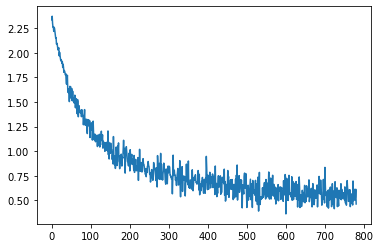

In [333]:
plt.plot(losses);

### Two layer net

In [476]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 100)
        self.lin2 = nn.Linear(100, 10)
    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [477]:
model = Mnist_NN().cuda()
model

Mnist_NN(
  (lin1): Linear(in_features=784, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=10, bias=True)
)

In [353]:
model(x).shape

torch.Size([64, 10])

In [357]:
lr = 2e-2
wd = 1e-5
def update(x, y, lr):
    y_hat = model(x)

    w2 = 0.
    for p in model.parameters():
        w2 += (p**2).sum()
    
    loss = loss_func(y_hat, y) + wd * w2
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [358]:
losses = [update(x, y, lr) for (x,y) in iter(data.train_dl)]

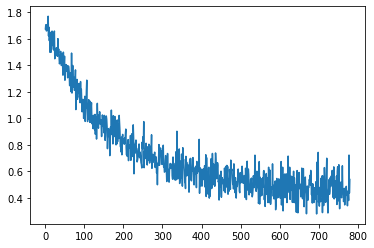

In [359]:
plt.plot(losses)

In [435]:
lr = 1e-3
wd = 1e-5
def update2(x, y, lr):
    opt = optim.Adam(model.parameters(), lr, weight_decay=wd)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [436]:
losses = [update2(x, y, lr) for (x,y) in iter(data.train_dl)]

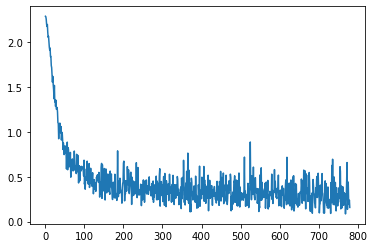

In [437]:
plt.plot(losses)

### Implement lr_find

In [478]:
lr = 1e-3
wd = 1e-5
def update3(x, y, model, lr):
    opt = optim.Adam(model.parameters(), lr, weight_decay=wd)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [483]:
def my_lr_find(model, update, lrs):
    losses = []
    for lr in lrs:
        x, y = next(iter(data.train_dl))
        loss = update(x, y, model, lr)
        losses.append(loss)
    return losses

In [484]:
import numpy as np

In [485]:
lrs = np.logspace(-6, -1, num=100)

In [515]:
model = Mnist_NN().cuda()

In [516]:
losses = my_lr_find(model, update3, lrs)

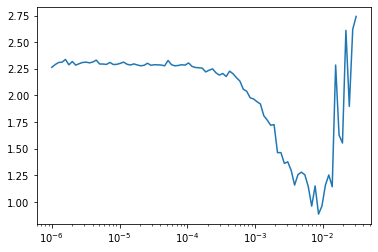

In [518]:
plt.plot(lrs[:90], losses[:90], scalex=False)
plt.xscale('log')
plt.show()

In [512]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


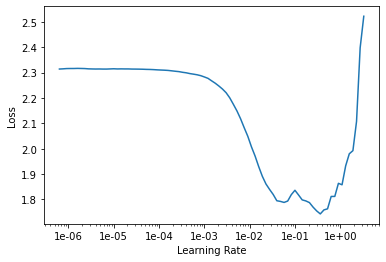

In [514]:
learn.lr_find()
learn.recorder.plot()

In [519]:
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.185839,0.159076,0.957000,00:02


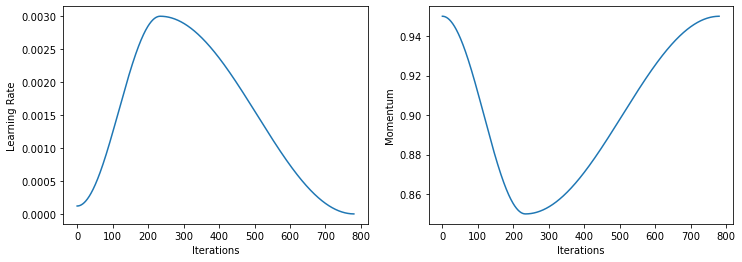

In [521]:
learn.recorder.plot_lr(show_moms=True)